<a href="https://colab.research.google.com/github/4myLab/codestates/blob/main/20220712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

In [3]:
# 이번에는 타겟으로 계절독감백신 접종여부를 사용하겠습니다.

target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
# 테스트 데이터 수를 n=14052 로 한정합니다.
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv').iloc[:14052]
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [4]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=len(test), stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((28102, 39), (14052, 39), (14052, 38))

In [5]:
def engineer(df):
  behaviorals = [col for col in df.columns if 'behavioral' in col]
  df['behaviorals'] = df[behaviorals].sum(axis=1)

  dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
  df.drop(columns=dels, inplace=True)

  return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [6]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [48]:
X_train

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,marital,rent_own_r,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,state,behaviorals
16637,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2.0,99.0,4,Non-MSA,2.0,3.0,5.0,8,UTAH,3.0
28688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,2.0,2,Non-MSA,1.0,3.0,4.0,5,OHIO,0.0
38018,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2.0,1.0,4,"MSA, Not Principle City",1.0,0.0,1.0,9,ARIZONA,5.0
4001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,1.0,3,"MSA, Not Principle City",2.0,1.0,3.0,4,GEORGIA,0.0
26756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,1.0,2,Non-MSA,2.0,3.0,5.0,5,ILLINOIS,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,4,Non-MSA,2.0,0.0,2.0,6,NEW MEXICO,2.0
6965,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,2.0,2.0,3,Non-MSA,1.0,0.0,1.0,4,ALABAMA,2.0
7839,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2.0,1.0,1,"MSA, Not Principle City",1.0,0.0,1.0,3,PENNSYLVANIA,5.0
7631,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1,"MSA, Principle City",2.0,2.0,4.0,1,MAINE,5.0


In [9]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.7548391688015941


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


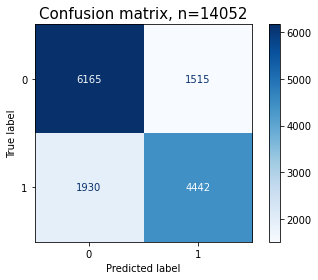

In [11]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
plt.title(f'Confusion matrix, n={len(y_val)}', fontsize=15)
plt.show()

In [12]:
cm = pcm.confusion_matrix
cm

array([[6165, 1515],
       [1930, 4442]])

In [13]:
cm[1][1]

4442

In [14]:
correct_predictions = np.diag(cm).sum()
correct_predictions

10607

In [18]:
total_predictions = cm.sum()
total_predictions

14052

In [19]:
correct_predictions / total_predictions

0.7548391688015941

In [20]:
print('검증 정확도: ', accuracy_score(y_val, y_pred))


검증 정확도:  0.7548391688015941


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      7680
           1       0.75      0.70      0.72      6372

    accuracy                           0.75     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.75      0.75     14052



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


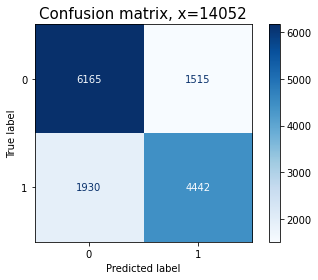

In [22]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
plt.title(f'Confusion matrix, x={len(y_val)}', fontsize=15)
plt.show()

In [23]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn

In [24]:
tp

4442

In [25]:
fp

1515

In [27]:
positives = tp + fp
tp/positives

0.7456773543730065

In [28]:
real_positives = tp+fn
real_positives

6372

In [29]:
tp/real_positives

0.697112366603892

In [30]:
herdImmunity = total*0.7
herdImmunity

9836.4

In [31]:
herdImmunity - real_positives

3464.3999999999996

In [33]:
true_ratio = y_train.value_counts(normalize=True)[1]
true_ratio

0.4534552700875383

In [34]:
public_vacc = 4500
overlap = public_vacc * true_ratio
overlap

2040.5487153939223

In [35]:
lack = herdImmunity - (public_vacc + real_positives - overlap)
lack

1004.9487153939226

In [37]:
pipe.classes_

array([0, 1])

In [38]:
pipe.predict(X_val)

array([1, 0, 0, ..., 1, 1, 0])

In [39]:
pipe.predict_proba(X_val)

array([[0.46      , 0.54      ],
       [0.85      , 0.15      ],
       [0.78      , 0.22      ],
       ...,
       [0.14      , 0.86      ],
       [0.38459524, 0.61540476],
       [0.92      , 0.08      ]])

In [40]:
y_pred_proba = pipe.predict_proba(X_val)[:,1]
y_pred_proba

array([0.54      , 0.15      , 0.22      , ..., 0.86      , 0.61540476,
       0.08      ])

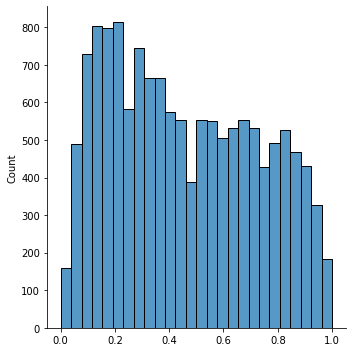

In [41]:
import seaborn as sns
sns.displot(y_pred_proba)

False    8095
True     5957
dtype: int64

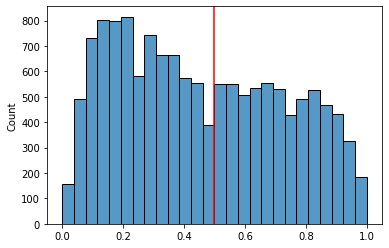

In [42]:
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [44]:
from ipywidgets import interact, fixed

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

<function __main__.explore_threshold>

In [46]:
pred_proba = pd.DataFrame({
    'y_val' : y_val,
    'pred_proba' : y_pred_proba
})
pred_proba

,y_val,pred_proba
10296,0,0.540000
3515,0,0.150000
13103,0,0.220000
31432,1,1.000000
38296,1,0.060000
...,...,...
6815,0,0.180000
34682,1,0.900000
21444,1,0.860000
19491,1,0.615405


In [47]:
top = pred_proba.sort_values(by='pred_proba', ascending=True)[:4500]
top

,y_val,pred_proba
10271,0,0.00
25027,0,0.00
37061,0,0.00
12209,0,0.00
4718,0,0.00
...,...,...
32901,0,0.27
39458,0,0.27
28620,0,0.27
34079,0,0.27


In [49]:
vc = top['y_val'].value_counts()
vc

0    3850
1     650
Name: y_val, dtype: int64

In [50]:
final = real_positives + vc[0]
final

10222

In [51]:
herdImmunity

9836.4

In [52]:
final > herdImmunity

True

In [53]:
vc_rand = pred_proba[pred_proba['pred_proba']<0.5].sample(4500, random_state=2)['y_val'].value_counts()
vc_rand

0    3455
1    1045
Name: y_val, dtype: int64

In [55]:
final_rand = real_positives + vc_rand[0]
final_rand

9827

In [56]:
final_rand > herdImmunity

False

In [57]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)':fpr,
    'TPRate(Recall)':tpr,
    'Threshold':thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.0000
1,0.000130,0.003766,1.0000
2,0.000391,0.009416,0.9900
3,0.000391,0.009730,0.9850
4,0.001042,0.016478,0.9800
...,...,...,...
526,0.995182,0.999215,0.0200
527,0.995313,0.999215,0.0140
528,0.995703,0.999215,0.0125
529,0.999089,1.000000,0.0100


Text(0, 0.5, 'TPR(Recall)')

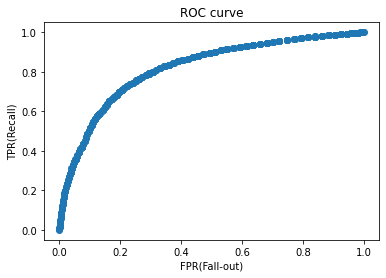

In [58]:
plt.scatter(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

In [59]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:',optimal_idx, ', threshold:', optimal_threshold)

idx: 256 , threshold: 0.4633333333333334


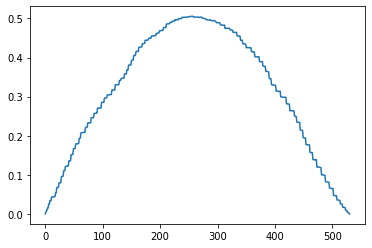

In [60]:
plt.plot(tpr-fpr);

In [61]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      7680
           1       0.73      0.74      0.73      6372

    accuracy                           0.75     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.75      0.75     14052



In [62]:
y_pred_optimal

array([ True, False, False, ...,  True,  True, False])

In [63]:
y_pred_05 = y_pred_proba >= 0.5
print(classification_report(y_val, y_pred_05))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      7680
           1       0.74      0.71      0.72      6372

    accuracy                           0.76     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.76      0.75     14052



In [64]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8187195322308537